# AR models (estimation, inference and prediction)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

## GNP Dataset 

The following dataset is from FRED: https://fred.stlouisfed.org/series/GNP. This is a quarterly dataset (there are four quarters in each year).

  observation_date      GNP
0       1947-01-01  244.142
1       1947-04-01  247.063
2       1947-07-01  250.716
3       1947-10-01  260.981
4       1948-01-01  267.133


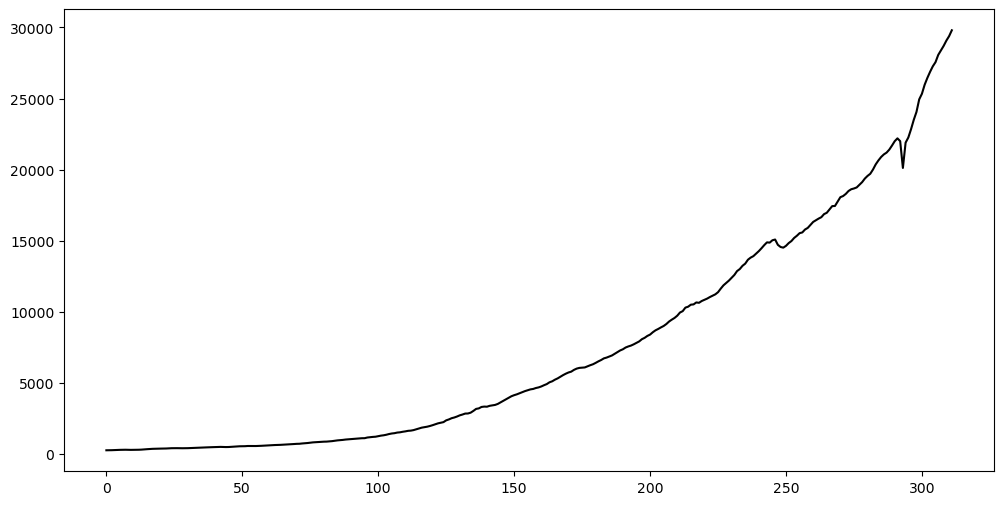

In [3]:
gnp = pd.read_csv("GNP_02April2025.csv")
print(gnp.head())

y = gnp['GNP']
plt.figure(figsize = (12, 6))
plt.plot(y, color = 'black')
plt.show()

Let us reserve the last 16 observations (corresponding to the most recent 4 years) for testing purposes. We shall fit models to the rest of the data, and then evaluate prediction accuracy on the last 16 observations.

In [4]:
n = len(y)
tme = range(1, n+1)

n_test = 16

n_train = n - n_test
y_train = y[:n_train]
tme_train = tme[:n_train]
y_test = y[n_train:]
tme_test = tme[n_train:]

## Model One: AR(p) directly on the training data

As seen in class, AR(p) can be fit in two ways. Either by using the AutoReg function (from the library statsmodels), or by manually creating $y$ and $X$ and then running OLS. Both methods give identical parameter estimates. But the standard errors will be slightly different (also AutoReg will use $z$-scores while OLS uses $t$-scores). Below we fit the AR(2) model for the GNP data using both these methods, and compare the results obtained. 

In [ ]:
p = 2
armod_sm = AutoReg(y_train, lags = p, trend = 'c').fit()
# trend = 'c' will fit the model y_t = phi_0 + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \epsilon_t
# trend = 'n' will fit the model y_t = \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \epsilon_t 
# (note there is no intercept term phi_0)
# the default choice is trend = 'c' so we can just drop it if we want
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                    GNP   No. Observations:                  296
Model:                     AutoReg(2)   Log Likelihood               -1912.402
Method:               Conditional MLE   S.D. of innovations            161.714
Date:                Thu, 03 Apr 2025   AIC                           3832.803
Time:                        21:06:22   BIC                           3847.538
Sample:                             2   HQIC                          3838.704
                                  296                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5376     13.295      2.071      0.038       1.480      53.595
GNP.L1         0.7827      0.057     13.751      0.000       0.671       0.894
GNP.L2         0.2273      0.057      3.961      0.0

Next let us fit the same model by running OLS (after creating the response vector and the design matrix).

In [ ]:
n_train = len(y_train)
yreg = y_train[p: ] # these are the response values in the autoregression
Xmat = np.ones((n_train - p, 1)) # this will be the design matrix (X) in the autoregression
for j in range(1, p + 1):
    col = y_train[p - j : n_train - j]
    Xmat = np.column_stack([Xmat, col])

armod = sm.OLS(yreg, Xmat).fit()
print(armod.summary())

                            OLS Regression Results                            
Dep. Variable:                    GNP   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.409e+05
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:06:22   Log-Likelihood:                -1912.4
No. Observations:                 294   AIC:                             3831.
Df Residuals:                     291   BIC:                             3842.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5376     13.363      2.061      0.0

Check that the parameter estimates are the same. The standard errors are quite close to each other. One of them gives z-scores while the other gives t-scores:

In [7]:
print(np.column_stack([armod.params, armod_sm.params]))
print(np.column_stack([armod.bse, armod_sm.bse])) # these are the standard errors

[[27.53762002 27.53762002]
 [ 0.78267356  0.78267356]
 [ 0.2272753   0.2272753 ]]
[[13.36316472 13.29481049]
 [ 0.0572102   0.05691756]
 [ 0.05767742  0.05738239]]


You are free to use either of these two methods while working with data. 

### Determination of the order $p$

One practical aspect of fitting AR(p) models is the determination of the order $p$. When $p$ increases, the models become more complicated and can overfit the data. The following heuristic can be used to determine $p$: 
1. Initialize at $p = 1$
2. Fit the AR(p) model to the data. Look at the 95% interval for the parameter $\phi_p$. If the interval contains 0, then use $p-1$ as the order. If the interval does not contain 0, then set $p = p+1$ and repeat Step 2. 

Let us apply this method to the GNP training data. The first step is to fit the AR(1) model. 

In [8]:
p = 1
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                    GNP   No. Observations:                  296
Model:                     AutoReg(1)   Log Likelihood               -1926.082
Method:               Conditional MLE   S.D. of innovations            165.696
Date:                Thu, 03 Apr 2025   AIC                           3858.164
Time:                        21:06:22   BIC                           3869.225
Sample:                             1   HQIC                          3862.593
                                  296                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.9779     13.531      1.698      0.089      -3.541      49.497
GNP.L1         1.0080      0.001    681.901      0.000       1.005       1.011
                                    Roots           

The 95% interval for $\phi_1$ is $[1.005, 1.011]$ which clearly does not contain zero. So we proceed to fit AR(2).

In [9]:
p = 2
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                    GNP   No. Observations:                  296
Model:                     AutoReg(2)   Log Likelihood               -1912.402
Method:               Conditional MLE   S.D. of innovations            161.714
Date:                Thu, 03 Apr 2025   AIC                           3832.803
Time:                        21:06:22   BIC                           3847.538
Sample:                             2   HQIC                          3838.704
                                  296                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5376     13.295      2.071      0.038       1.480      53.595
GNP.L1         0.7827      0.057     13.751      0.000       0.671       0.894
GNP.L2         0.2273      0.057      3.961      0.0

The 95% interval for $\phi_2$ is $[0.115, 0.340]$ which also does not contain 0. So we increase $p$ and proceed to fit AR(3). 

In [10]:
p = 3
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                    GNP   No. Observations:                  296
Model:                     AutoReg(3)   Log Likelihood               -1900.679
Method:               Conditional MLE   S.D. of innovations            158.859
Date:                Thu, 03 Apr 2025   AIC                           3811.357
Time:                        21:06:22   BIC                           3829.758
Sample:                             3   HQIC                          3818.727
                                  296                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.7792     13.315      2.687      0.007       9.683      61.876
GNP.L1         0.7197      0.059     12.225      0.000       0.604       0.835
GNP.L2         0.0467      0.077      0.604      0.5

The 95% interval for $\phi_3$ is $[0.104, 0.387]$ which also does not contain 0. So we increase $p$ again and proceed to fit AR(4). 

In [11]:
p = 4
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                    GNP   No. Observations:                  296
Model:                     AutoReg(4)   Log Likelihood               -1894.593
Method:               Conditional MLE   S.D. of innovations            159.078
Date:                Thu, 03 Apr 2025   AIC                           3801.186
Time:                        21:06:22   BIC                           3823.247
Sample:                             4   HQIC                          3810.023
                                  296                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.1435     13.528      2.598      0.009       8.629      61.658
GNP.L1         0.7188      0.059     12.185      0.000       0.603       0.834
GNP.L2         0.0310      0.086      0.359      0.7

The 95% interval for $\phi_4$ is $[-0.406, 0.266]$. This interval contains 0 which suggests that $\phi_4$ term is redundant. So we use $p = 3$ for this dataset.

### Predictions

The fitted AR(3) can be used to generate point predictions for the future 16 observations. 

In [12]:
p = 3
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                    GNP   No. Observations:                  296
Model:                     AutoReg(3)   Log Likelihood               -1900.679
Method:               Conditional MLE   S.D. of innovations            158.859
Date:                Thu, 03 Apr 2025   AIC                           3811.357
Time:                        21:06:22   BIC                           3829.758
Sample:                             3   HQIC                          3818.727
                                  296                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.7792     13.315      2.687      0.007       9.683      61.876
GNP.L1         0.7197      0.059     12.225      0.000       0.604       0.835
GNP.L2         0.0467      0.077      0.604      0.5

In [13]:
k = 16
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean # this gives the point predictions

The predictions can also be calculated manually (without using the get_prediction function) as follows (this was discussed in class).

In [ ]:
# Predictions
yhat = np.concatenate([y_train.astype(float), np.full(k, -9999)]) # extend data by k placeholder values
phi_vals = armod_sm.params
for i in range(1, k + 1):
    ans = phi_vals.iloc[0]
    for j in range(1, p + 1):
        ans += phi_vals.iloc[j] * yhat[n_train + i - j - 1]
    yhat[n_train + i - 1] = ans
predvalues = yhat[n_train: ]

# Check that both predictions are identical:
print(np.column_stack([predvalues, fcast_mean]))

[[22015.82610003 22015.82610003]
 [22297.35726353 22297.35726353]
 [22577.46189255 22577.46189255]
 [22733.34849543 22733.34849543]
 [22927.7624808  22927.7624808 ]
 [23143.75177595 23143.75177595]
 [23346.56851705 23346.56851705]
 [23550.37282678 23550.37282678]
 [23759.57018454 23759.57018454]
 [23969.4607915  23969.4607915 ]
 [24180.3448357  24180.3448357 ]
 [24393.30052786 24393.30052786]
 [24607.96390436 24607.96390436]
 [24824.19709577 24824.19709577]
 [25042.14861695 25042.14861695]
 [25261.82954785 25261.82954785]]


Below we plot the predictions along with the datapoints from the test set (actual last 16 observations) that we previously set aside. 

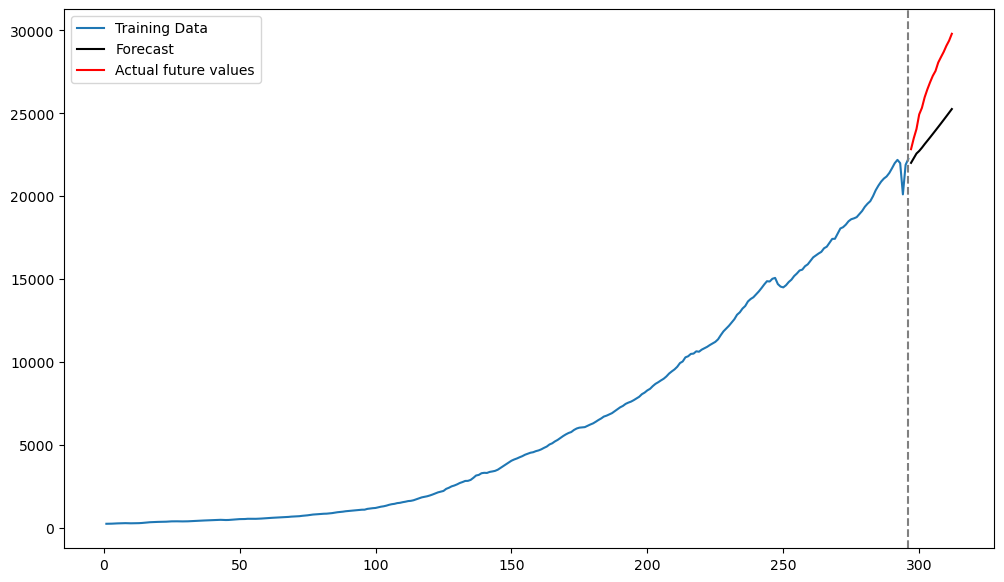

In [ ]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, fcast_mean, label = 'Forecast', color = 'black')
plt.plot(tme_test, y_test, color = 'red', label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

The predictions by the AR(3) model are decent but there are not very accurate. 

## Model Two: AR(p) model on the log(data)

Instead of fitting AR(p) models directly on the observed GNP training data, it makes sense to fit them to the logarithmed data. This method will also give predictions on the log-scale, which will need to be exponentiated to obtain predictions on the original scale. 

In [16]:
ylog_train = np.log(y_train)
ylog_test = np.log(y_test)

Here is the code for the automatic procedure that iteratively fits AR(p) models, starting from $p = 1$ and incrementing $p$ by 1 each time, until the 95% confidence interval for $\phi_p$ (the lag-p coefficient) includes 0 (the procedure then stops and reports the last model).

In [ ]:
max_p = 20
p = 1
while p <= max_p:
    armd = AutoReg(ylog_train, lags = p).fit()
    conf_ints = armd.conf_int(alpha = 0.05)
    lower, upper = conf_ints.iloc[-1] 
    # sometimes this is throwing an error saying that conf_ints is not a pandas array 
    # (in such cases, use conf_ints[-1,:])
    if (lower < 0 < upper):
        print(f"Stopping at p = {p} because 0 is in the phi_{p} interval")
        break
    p += 1
if p >= max_p:
    print(f"Reached p = {max_p} without finding a phi_p interval containing 0")
p = p - 1 # note that if the algorithm outputs p = 4, we should take p = 3

print(p)

Stopping at p = 4 because 0 is in the phi_4 interval
3


Now let us fit the AR(p) model (with $p$ selected as above) to the logarithm of the GNP data.

In [18]:
armod_sm = AutoReg(ylog_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                    GNP   No. Observations:                  296
Model:                     AutoReg(3)   Log Likelihood                 870.225
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Thu, 03 Apr 2025   AIC                          -1730.451
Time:                        21:06:22   BIC                          -1712.050
Sample:                             3   HQIC                         -1723.081
                                  296                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.005      4.213      0.000       0.011       0.030
GNP.L1         1.1730      0.058     20.342      0.000       1.060       1.286
GNP.L2         0.0029      0.093      0.032      0.9

Below we predict the next 16 values. 

In [19]:
k = 16
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean # this gives the point predictions

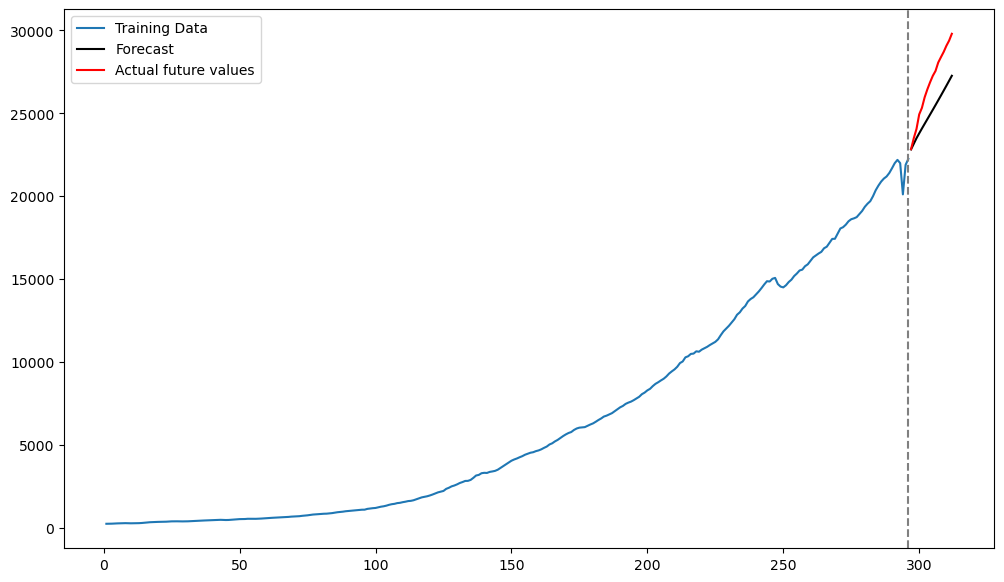

In [20]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, np.exp(fcast_mean), label = 'Forecast', color = 'black') # Note the exponentiation
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

Compare these predictions with those obtained from Method One. The predictions from Model Two seem closer (compared to Model One) to the actual values but the accuracy is still not very good. 

## Model Three: Working with Differenced Data

Instead of working with log GNP data, it is common to work their differences: 
\begin{equation*}
   y_t = \log \text{GNP}_t - \log \text{GNP}_{t-1} = \log \frac{\text{GNP}_{t}}{\text{GNP}_{t-1}}
\end{equation*}
Because $\log x \approx x-1$, as we remarked previously, $100 y_t$ represents the percentage change in GNP from year $t-1$ to year $t$. 

The differenced log-data look very different from the original data and the log-data. 

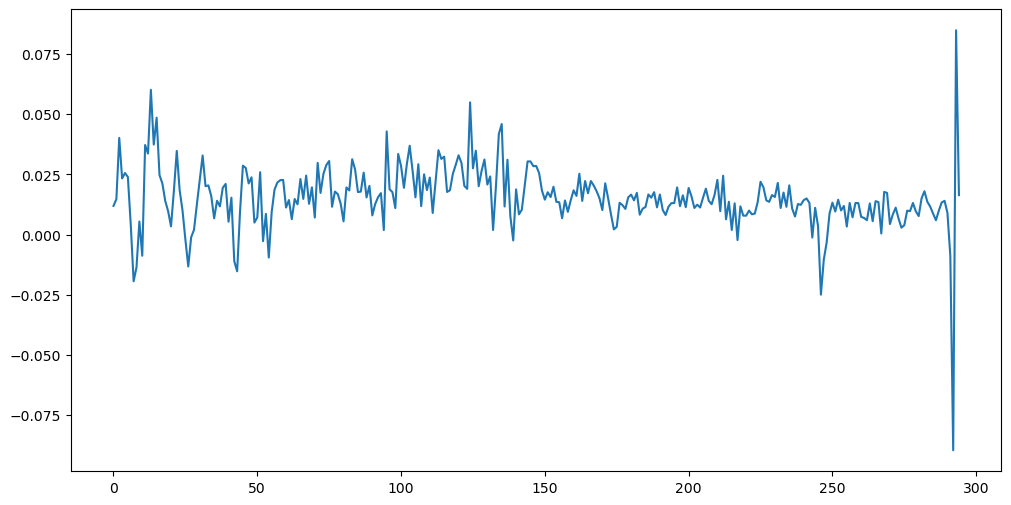

In [21]:
ylogdiff_train = np.diff(ylog_train)

plt.figure(figsize = (12, 6))
plt.plot(ylogdiff_train) 
plt.show()

Notice that the differenced log-data has  no "trend". The trend has been removed by differencing.

In [ ]:
max_p = 20
p = 1
while p <= max_p:
    armd = AutoReg(ylogdiff_train, lags = p).fit()
    conf_ints = armd.conf_int(alpha = 0.05)
    lower, upper = conf_ints[-1, :]
    if (lower < 0 < upper):
        print(f"Stopping at p = {p} because 0 is in the phi_{p} interval")
        break
    p += 1
if p >= max_p:
    print(f"Reached p = {max_p} without finding a phi_p interval containing 0")
p = p-1 #note that if the algorithm outputs p = 4, we should take p = 3

print(p)

Stopping at p = 3 because 0 is in the phi_3 interval
2


We now fit the AR model with the chosen $p$.

In [23]:
armod_sm = AutoReg(ylogdiff_train, lags = p, trend = 'c').fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  295
Model:                     AutoReg(2)   Log Likelihood                 867.445
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Thu, 03 Apr 2025   AIC                          -1726.889
Time:                        21:06:22   BIC                          -1712.169
Sample:                             2   HQIC                         -1720.993
                                  295                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.001      7.030      0.000       0.007       0.012
y.L1           0.1948      0.057      3.389      0.001       0.082       0.307
y.L2           0.2051      0.060      3.395      0.0

Now we obtain predictions. We can use the same method as before to generate predictions for the future 16 values. 

In [24]:
k = 16
fcast = armod_sm.get_prediction(start = n_train - 1, end = n_train + k - 2)
fcast_mean = fcast.predicted_mean # this gives the point predictions

However that these predictions are for the differenced log-data (they are not for the original data). To be clear, suppose $y_t$ denotes $\log(\text{GNP}_t)$. Then we obtained predictions for the future 16 values of $y_t - y_{t-1}$ i.e., $y_{n+1} - y_n, y_{n+2} - y_{n+1}, ..., y_{n+k} - y_{n+k-1}$. But we need predictions for $y_t$ not for these differences. To compute the predictions for $y_t$, we can simply do the following: 
\begin{equation*}
   \hat{y}_{n+1} = y_n + \widehat{y_{n+1} - y_n}
\end{equation*}
and
\begin{equation*}
   \hat{y}_{n+2} = \hat{y}_{n+1} + \widehat{y_{n+2} - y_{n+1}}
\end{equation*}
and so on recursively computing $\hat{y}_{n+3}$, $\hat{y}_{n+4}$ etc. This process is implemented in the code below. Note that we have to exponentiate the predictions for $y_t$ in the end because for $\text{GNP}_t = \exp(y_t)$.

In [ ]:
last_observed_log = ylog_train.iloc[-1]
log_forecast = np.zeros(k)
log_forecast[0] = last_observed_log + fcast_mean[0]
for i in range(1, k):
    log_forecast[i] = log_forecast[i - 1] + fcast_mean[i]
original_scale_forecast = np.exp(log_forecast)

Below we plot these predictions along with the actual test values. 

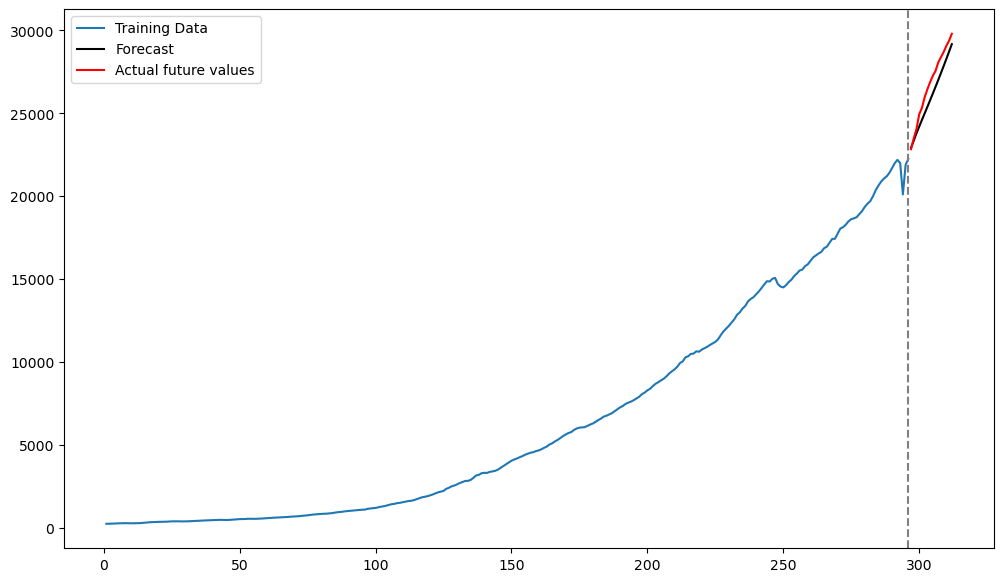

In [26]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, original_scale_forecast, label = 'Forecast', color = 'black')
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

It is very interesting that these predictions are much more accurate compared to the predictions obtained by the previous two models. This suggests that AR(p) models are better for the difference log-data than for the log-data without differencing (and also for the original data).

The following is another way of obtaining the predictions for the original data from the model fitted to the differenced data. The AR(2) model that we just fitted to $y_t = \log \text{GNP}_t - \log \text{GNP}_{t-1}$ is: 
\begin{equation*}
   y_t = \hat{\phi}_0 + \hat{\phi}_1 y_{t-1} + \hat{\phi}_2 y_{t-2} + \epsilon_t
\end{equation*}
If we replace $y_t$ by $\log \text{GNP}_t - \log \text{GNP}_{t-1}$ and rewrite the equation above, we obtain:
\begin{equation*}
   \log \text{GNP}_t = \hat{\phi}_0 + (\hat{\phi}_1 + 1) \log \text{GNP}_{t-1} + \left(\hat{\phi}_2 - \hat{\phi}_1 \right) \log \text{GNP}_{t-2} - \hat{\phi}_2 \log \text{GNP}_{t-3} + \epsilon_t
\end{equation*}
Thus in terms of $\log \text{GNP}_t$, the fitted model can be interpreted as an AR(3) model. However, it is a special kind of AR(3) model (for example, the sum of the fitted coefficients for $\log \text{GNP}_{t-1}$, $\log \text{GNP}_{t-2}$, $\log \text{GNP}_{t-3}$ equals 0). We can compare this special AR(3) model to the model obtained by fitting AR(3) to the $\log \text{GNP}_t$ data:

In [ ]:
phi_vals = np.array([armod_sm.params[0], armod_sm.params[1] + 1, 
                     armod_sm.params[2] - armod_sm.params[1], -armod_sm.params[2]]) 
# these are the fitted coefficients in the AR(3) model derived from AR(2) applied to the differences
armod_nodiff = AutoReg(ylog_train, lags = 3).fit()
print(np.column_stack([phi_vals, armod_nodiff.params]))

[[ 0.00924128  0.02014238]
 [ 1.194775    1.17303216]
 [ 0.01035034  0.0029458 ]
 [-0.20512534 -0.17724759]]


It is interesting that the parameter estimates are somewhat similar but not exactly the same. 

With this AR(3) model for $\log \text{GNP}_t$ that is derived from the AR(2) model for $y_t = \log \text{GNP}_t - \log \text{GNP}_{t-1}$, we can obtain predictions in the usual way as follows. 

In [ ]:
yhat = np.concatenate([ylog_train.astype(float), np.full(k, -9999)]) # extend data by k placeholder values
p = len(phi_vals) - 1
for i in range(1, k + 1):
    ans = phi_vals[0]
    for j in range(1, p + 1):
        ans += phi_vals[j] * yhat[n_train + i - j - 1]
    yhat[n_train + i - 1] = ans
predvalues = yhat[n_train: ]

print(predvalues)

[10.0401751  10.05858192 10.07752672 10.09423368 10.11061512 10.12647412
 10.14216459 10.15771507 10.17320371 10.18865159 10.20407884 10.21949372
 10.23490196 10.25030637 10.26570866 10.28110976]


These predictions coincide with the predictions obtained previously. 

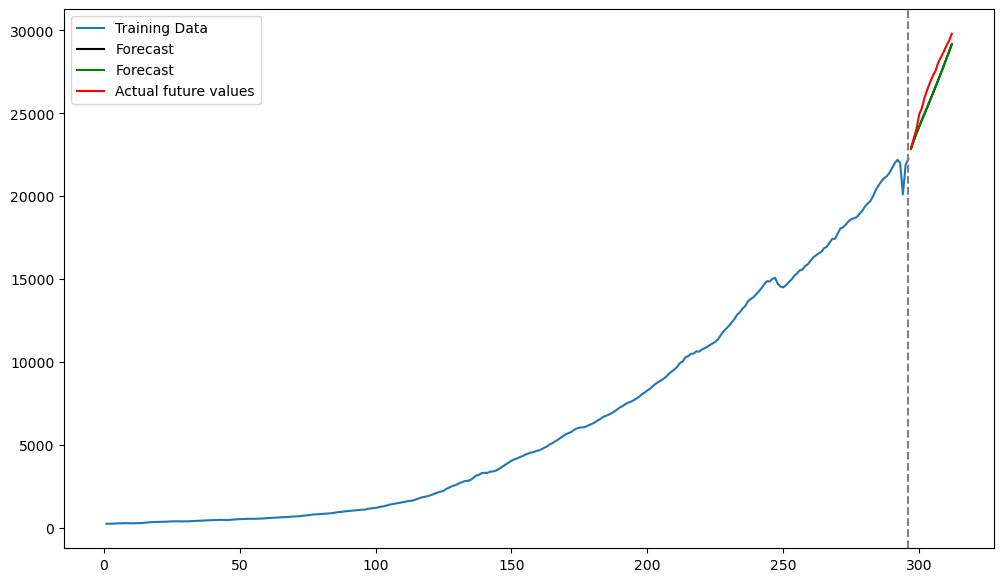

In [29]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, original_scale_forecast, label = 'Forecast', color = 'black')
plt.plot(tme_test, np.exp(predvalues), label = 'Forecast', color = 'green')
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

The green and black predictions coincide above. 

To conclude, predictions from the AR(3) model applied directly to the $\log \text{GNP}$ data are different from the predictions obtained by AR(2) fitted to the differences of $\log \text{GNP}$. It is quite common, while using AR models, to work with differenced data. 